In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc

url = "https://raw.githubusercontent.com/Walfeinick/dpo-walfeinick-rep/main/data/S05-hw-dataset.csv"
data = pd.read_csv(url)

print(data.head())
print(f"\n информация о датасете")
print(data.info())
print(f"\n Описание")
print(data.describe())
print(f"\n Анализ ")
print(data['default'].value_counts(normalize=True)) #вывод распределения

   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

1. Датасет содержит 3000 объектов и 17 признаков, включая целевой default.
2. Пропущенных значений нет. Явных аномалий в данных не обнаружено.
3. Таргет распределен для не произошедшего и произошедшего дефолта в значениях 59% и 41% соответственно

In [11]:
X = data.drop(columns = ['default', 'client_id']) #матрица признаков
y = data['default'] #таргет

print("Размерность признаков X:", X.shape)
print("Размерность таргета y:", y.shape)

#деление данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

baseline = DummyClassifier(strategy ="most_frequent", random_state=42 )
baseline.fit(X_train, y_train)
y_predicted = baseline.predict(X_test)
y_proba = baseline.predict_proba(X_test)[:,1]
accuracy_dumb = accuracy_score(y_test, y_predicted)
roc_auc_dumb = roc_auc_score(y_test, y_proba)

print("\nОценка DummyClassifier:")
print(f"Strategy: 'most_frequent' (всегда предсказывает самый частый класс)")
print(f"Accuracy на тесте: {accuracy_dumb:.3f}")
print(f"ROC-AUC на тесте: {roc_auc_dumb:.3f}")

# Что предсказывает модель
most_frequent_class = y_train.mode()[0]
most_frequent_proportion = y_train.value_counts(normalize=True).max()
print(f"\nМодель всегда предсказывает класс: {most_frequent_class}")
print(f"Доля этого класса в данных: {most_frequent_proportion:.1%}")
print(f"Accuracy равна этой доле: {most_frequent_proportion:.3f}")

Размерность признаков X: (3000, 15)
Размерность таргета y: (3000,)

Оценка DummyClassifier:
Strategy: 'most_frequent' (всегда предсказывает самый частый класс)
Accuracy на тесте: 0.589
ROC-AUC на тесте: 0.500

Модель всегда предсказывает класс: 0
Доля этого класса в данных: 59.0%
Accuracy равна этой доле: 0.590


Бейзлайн всегда предсказывает самый частый клас, 0 = "нет дефолта". Это даёт accuracy = 0.600 (доля этого класса в данных) и ROC-AUC = 0.500 (как случайное угадывание). Таков минимальный порог - любая реальная модель должна превзойти эти значения, чтобы считаться полезной.

Лучшие параметры: {'logreg__C': 1.0}
Лучший ROC-AUC (кросс-валидация): 0.863

Оценка на тесте:
Accuracy:  0.793
ROC-AUC:   0.865
Confusion Matrix:
[[382  60]
 [ 95 213]]


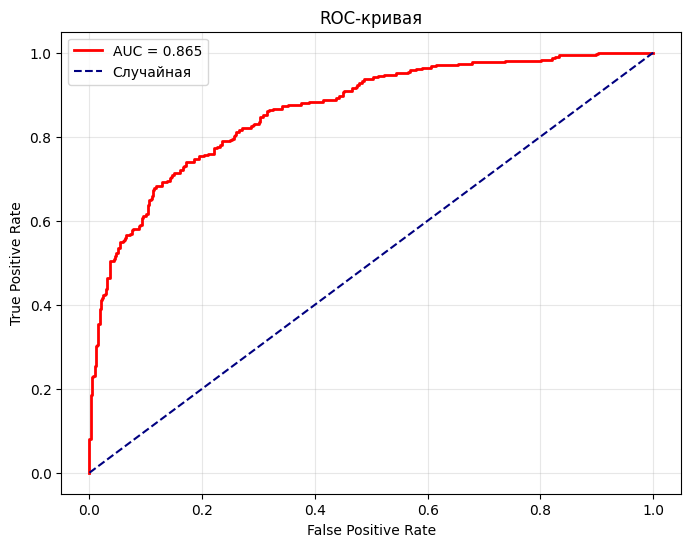

In [25]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter= 1000, random_state=42))
])

param_grid = {"logreg__C": [0.01, 0.1, 1.0, 10.0]}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC (кросс-валидация): {grid_search.best_score_:.3f}")

# оценка лучшей модели на тестовой выборке
best_model = grid_search.best_estimator_
y_predicted = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Метрики
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"\nОценка на тесте:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Случайная')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(alpha=0.3)

figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)
figure_path = os.path.join(figures_dir, "roc_curve_logreg.png")
plt.savefig(figure_path, dpi=150)
plt.show()


In [26]:
results = pd.DataFrame({
    'Модель': ['DummyClassifier', 'LogisticRegression'],
    'Accuracy': [accuracy_dumb, accuracy],
    'ROC-AUC': [roc_auc_dumb, roc_auc],
    'Лучший C': ['-', grid_search.best_params_['logreg__C']]
})

print("Сравнение моделей")
print(results.to_string(index=False))

#все значение С
cv_results = pd.DataFrame(grid_search.cv_results_)
c_values = cv_results[['param_logreg__C', 'mean_test_score']].sort_values('param_logreg__C')
print("\nВлияние параметра C на ROC-AUC (кросс-валидация):")
for _, row in c_values.iterrows():
    print(f"  C = {row['param_logreg__C']}: ROC-AUC = {row['mean_test_score']:.7f}")

Сравнение моделей
            Модель  Accuracy  ROC-AUC Лучший C
   DummyClassifier  0.589333 0.500000        -
LogisticRegression  0.793333 0.864709      1.0

Влияние параметра C на ROC-AUC (кросс-валидация):
  C = 0.01: ROC-AUC = 0.8630352
  C = 0.1: ROC-AUC = 0.8631655
  C = 1.0: ROC-AUC = 0.8631696
  C = 10.0: ROC-AUC = 0.8631287


Логистическая регрессия превосходит бейслайн по ROC_AUC, но показывает меньший рост accuracy. Так происходит, потому что ROC-AUC оценивает способность разделять классы, а acuuracy просто считает именно правильные ответы.
Изменение С влияло на качество: слишком сильная ухудшала результаты, а оптимальное значение находится где то в диапазоне 0.1-10.0

Для решения этой задачи логистическая регрессия неплохой выбор, она лучше разделяет классы, чем случайная модель и автоматически балансирует признаки.